In [1]:
import statsmodels.api as sm
from sklearn import datasets ## imports datasets from scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
data = datasets.load_boston() ## loads Boston dataset from datasets library 

df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=["MEDV"])
# Concatenate y in the dataframe
df_target = pd.concat([df,target], axis=1)

In [3]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [4]:
df_target.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

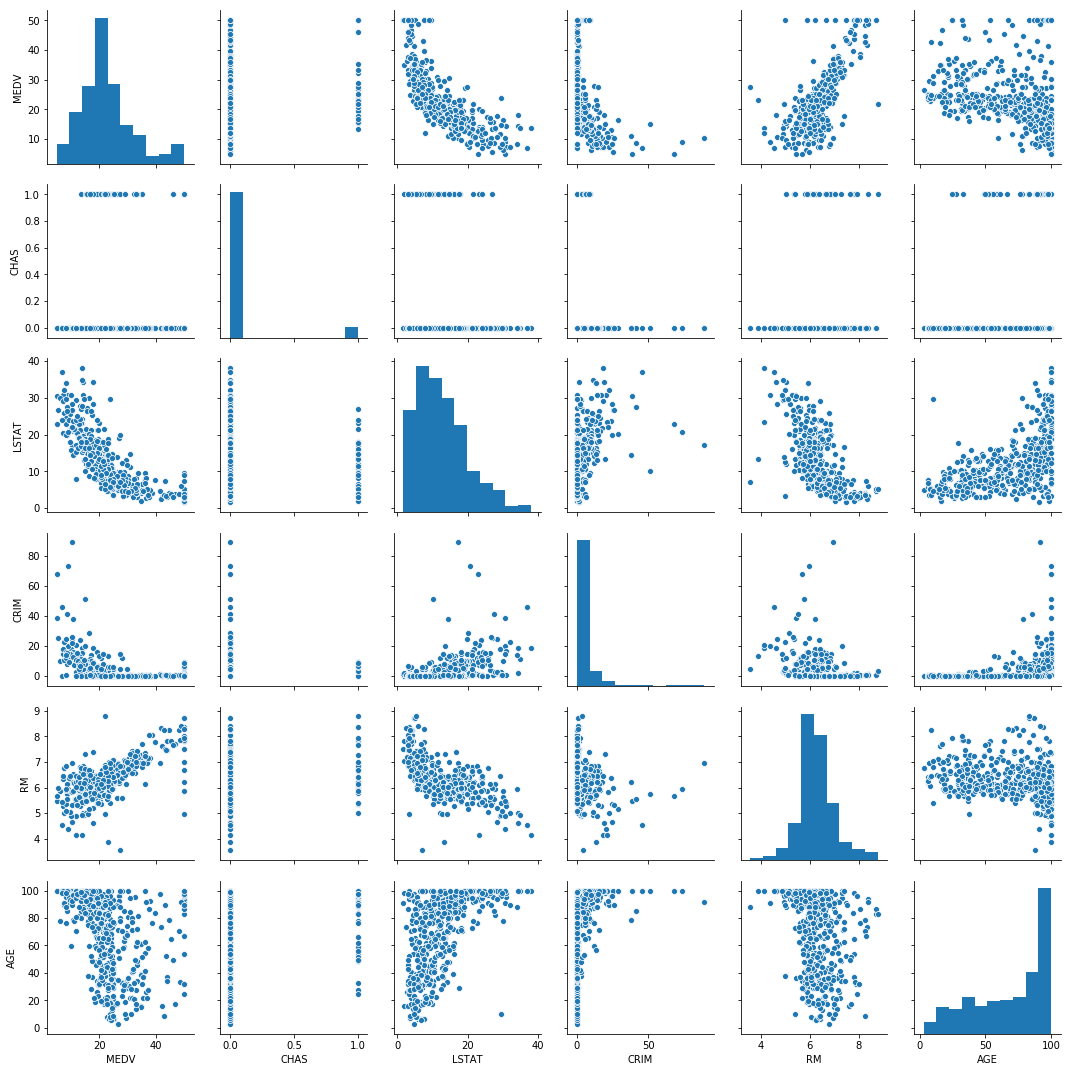

In [5]:
import seaborn as sns
sns.pairplot(df_target[['MEDV','CHAS','LSTAT','CRIM','RM','AGE']])
plt.show()

# Compare Nested Models

In [6]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [7]:
model_1 = smf.ols(formula='MEDV ~ CHAS + np.log(LSTAT)', data=df_target).fit()
model_2 = smf.ols(formula='MEDV ~ CHAS + np.log(LSTAT) + RM + AGE', data=df_target).fit()

In [8]:
anovaResults = anova_lm(model_1, model_2)
print(anovaResults) 
# Notes:
# 1. You can ignore the warnings. The warnings are because the values in the first line are empty (NaN). 
#    numpy package will issue warnings for NaN values
# 2. ssr in the output are RSS or SSE

   df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0     503.0  13745.627431      0.0         NaN        NaN           NaN
1     501.0  11774.839381      2.0  1970.78805  41.926891  1.458818e-17


/Users/chenghua/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/chenghua/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/chenghua/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Best Subset Selection

In [9]:
# First create some dummy variables for categorical variables. This is another way of including categorical varaibles
df_dummy = pd.get_dummies(df, columns = ['CHAS'],drop_first = True) # Change categorical to one-hot
df_dummy.head(3)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1.0
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0


In [10]:
import itertools
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
y = target
X = df_dummy.drop(columns=['ZN','INDUS','NOX','RAD']) # we don't include these variables in the model
k = 9
RSS_list, R_squared_list, adj_R_squared_list, AIC_list, BIC_list, feature_list = [],[],[],[],[],[]
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'): # note that for python range(2) = 0,1

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        X_c = sm.add_constant(X[list(combo)])       # we need to add constant term using sm.OLS
        model = sm.OLS(y, X_c).fit()                # run the regression model
        
        RSS_list.append(model.ssr)                  # model.ssr is the sum of squared residuals
        R_squared_list.append(model.rsquared)
        adj_R_squared_list.append(model.rsquared_adj)
        AIC_list.append(model.aic)
        BIC_list.append(model.bic)
        feature_list.append(combo)
        numb_features.append(len(combo))   

# Store the results in DataFrame
df_results = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list,'R_squared':R_squared_list,'features':feature_list,'adj_R_squared':adj_R_squared_list,'AIC':AIC_list,'BIC':BIC_list})

In [12]:
df_results

,numb_features,RSS,R_squared,features,adj_R_squared,AIC,BIC
0,1,36275.512356,0.150780,"(CRIM,)",0.149096,3601.780731,3610.233804
1,1,22061.879196,0.483525,"(RM,)",0.482501,3350.151117,3358.604191
2,1,36646.534350,0.142095,"(AGE,)",0.140393,3606.929757,3615.382830
3,1,40048.048843,0.062464,"(DIS,)",0.060604,3651.842869,3660.295942
4,1,33338.961320,0.219526,"(TAX,)",0.217977,3559.066134,3567.519207
...,...,...,...,...,...,...,...
506,8,12904.325545,0.697906,"(CRIM, RM, AGE, TAX, PTRATIO, B, LSTAT, CHAS_1.0)",0.693044,3092.789072,3130.827902
507,8,12359.866015,0.710652,"(CRIM, RM, DIS, TAX, PTRATIO, B, LSTAT, CHAS_1.0)",0.705995,3070.976446,3109.015276
508,8,15229.787378,0.643467,"(CRIM, AGE, DIS, TAX, PTRATIO, B, LSTAT, CHAS_...",0.637728,3176.628534,3214.667364
509,8,12318.232340,0.711627,"(RM, AGE, DIS, TAX, PTRATIO, B, LSTAT, CHAS_1.0)",0.706985,3069.269129,3107.307959


In [14]:
# Get the minimum RSS for each numb_features
df_minRSS = df_results[df_results.groupby('numb_features')['RSS'].transform(min) == df_results['RSS']] 
df_minRSS

,numb_features,RSS,R_squared,features,adj_R_squared,AIC,BIC
7,1,19472.381418,0.544146,"(LSTAT,)",0.543242,3286.974957,3295.428030
22,2,15439.309201,0.638562,"(RM, LSTAT)",0.637124,3171.542314,3184.221924
89,3,13727.985314,0.678624,"(RM, PTRATIO, LSTAT)",0.676704,3114.097267,3131.003414
205,4,13228.907703,0.690308,"(RM, DIS, PTRATIO, LSTAT)",0.687835,3097.359045,3118.491728
351,5,12726.266046,0.702075,"(RM, DIS, PTRATIO, B, LSTAT)",0.699095,3079.758446,3105.117666
456,6,12495.082016,0.707487,"(RM, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.703970,3072.481987,3102.067744
497,7,12397.809245,0.709764,"(RM, AGE, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.705684,3070.527422,3104.339716
505,8,12297.912621,0.712103,"(CRIM, RM, AGE, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.707468,3068.433761,3106.472591
510,9,12264.199498,0.712892,"(CRIM, RM, AGE, DIS, TAX, PTRATIO, B, LSTAT, C...",0.707682,3069.044723,3111.310089


In [15]:
# Get max R^2 for each numb_features. 
# We can verify that it is the same as min RSS
df_maxRsqr = df_results[df_results.groupby('numb_features')['R_squared'].transform(max) == df_results['R_squared']] 
df_maxRsqr

,numb_features,RSS,R_squared,features,adj_R_squared,AIC,BIC
7,1,19472.381418,0.544146,"(LSTAT,)",0.543242,3286.974957,3295.428030
22,2,15439.309201,0.638562,"(RM, LSTAT)",0.637124,3171.542314,3184.221924
89,3,13727.985314,0.678624,"(RM, PTRATIO, LSTAT)",0.676704,3114.097267,3131.003414
205,4,13228.907703,0.690308,"(RM, DIS, PTRATIO, LSTAT)",0.687835,3097.359045,3118.491728
351,5,12726.266046,0.702075,"(RM, DIS, PTRATIO, B, LSTAT)",0.699095,3079.758446,3105.117666
456,6,12495.082016,0.707487,"(RM, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.703970,3072.481987,3102.067744
497,7,12397.809245,0.709764,"(RM, AGE, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.705684,3070.527422,3104.339716
505,8,12297.912621,0.712103,"(CRIM, RM, AGE, DIS, PTRATIO, B, LSTAT, CHAS_1.0)",0.707468,3068.433761,3106.472591
510,9,12264.199498,0.712892,"(CRIM, RM, AGE, DIS, TAX, PTRATIO, B, LSTAT, C...",0.707682,3069.044723,3111.310089


In [16]:
# Adding columns to the dataframe with RSS and R squared values of the best subset
# This is for plotting purpose only
df_results['min_RSS'] = df_results.groupby('numb_features')['RSS'].transform(min)
df_results['max_R_squared'] = df_results.groupby('numb_features')['R_squared'].transform(max)
df_results.head()

,numb_features,RSS,R_squared,features,adj_R_squared,AIC,BIC,min_RSS,max_R_squared
0,1,36275.512356,0.150780,"(CRIM,)",0.149096,3601.780731,3610.233804,19472.381418,0.544146
1,1,22061.879196,0.483525,"(RM,)",0.482501,3350.151117,3358.604191,19472.381418,0.544146
2,1,36646.534350,0.142095,"(AGE,)",0.140393,3606.929757,3615.382830,19472.381418,0.544146
3,1,40048.048843,0.062464,"(DIS,)",0.060604,3651.842869,3660.295942,19472.381418,0.544146
4,1,33338.961320,0.219526,"(TAX,)",0.217977,3559.066134,3567.519207,19472.381418,0.544146


/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


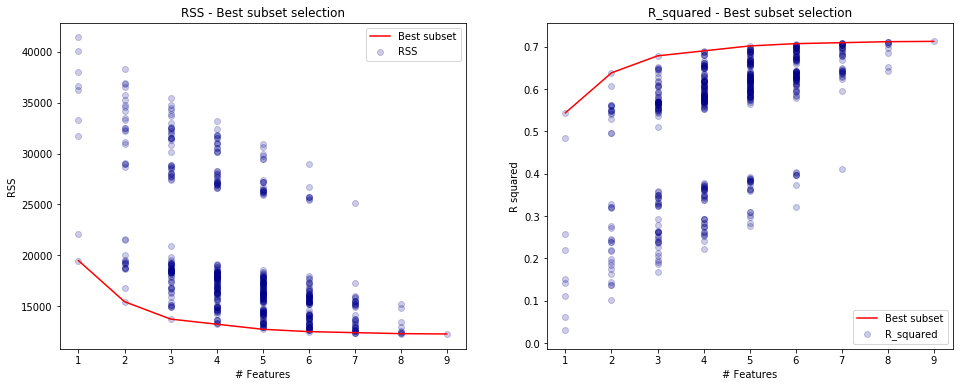

In [17]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df_results.numb_features,df_results.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df_results.numb_features,df_results.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df_results.numb_features,df_results.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df_results.numb_features,df_results.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()
# Ignore the warnings

/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


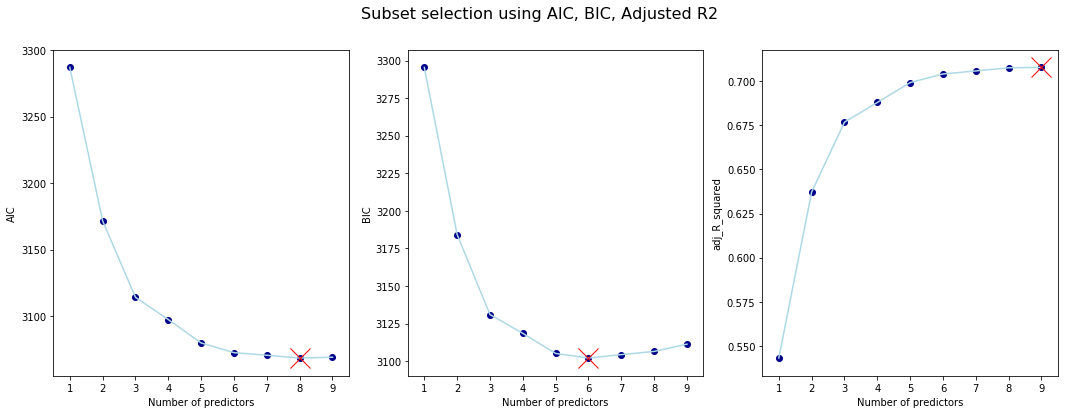

In [18]:
standards = ['AIC','BIC','adj_R_squared']
df_maxRsqr.index = df_maxRsqr.numb_features       # need to reset index to 1,2,3.. for this to plot the red X
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(standards):
    ax = fig.add_subplot(1, len(standards), i+1)
    ax.plot(df_maxRsqr['numb_features'],df_maxRsqr[v], color = 'lightblue')
    ax.scatter(df_maxRsqr['numb_features'],df_maxRsqr[v], color = 'darkblue')
    if v == 'adj_R_squared':
        ax.plot(df_maxRsqr[v].idxmax(),df_maxRsqr[v].max(), marker = 'x', markersize = 20, color='r')
    else:
        ax.plot(df_maxRsqr[v].idxmin(),df_maxRsqr[v].min(), marker = 'x', markersize = 20, color='r')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

# Forward Stepwise Selection

In [19]:
#Initialization variables
y = target
X = df_dummy.drop(columns=['ZN','INDUS','NOX','RAD'])     # we don't include these variables in the model
k = 9

remaining_features = list(X.columns.values)               # Initialize the remaining features as all features
features = []
RSS_list, R_squared_list, adj_R_squared_list, AIC_list, BIC_list = [],[],[],[],[] 
features_list = dict()                                    # Intialize feature list using dictionary. This is one way

for i in range(1,k+1):
    best_RSS = np.inf                                     # initialize the best_RSS in each round to be infinity
    
    for combo in itertools.combinations(remaining_features,1): # iterate through all remaining features
        
        X_c = sm.add_constant(X[list(combo) + features])  # we need to add constant term using sm.OLS
        model = sm.OLS(y, X_c).fit()

        if model.ssr < best_RSS:                          # compare the RSS value with the smallest value in this round
            best_RSS = model.ssr                          # update the best value
            best_R_squared = model.rsquared               # update best best_R_squared
            best_feature = combo[0]                       # the best feature in this round
            best_aic = model.aic
            best_bic = model.bic
            best_adj_R_squared = model.rsquared_adj

    #Updating variables for next loop
    features.append(best_feature)                         # add the best feature in the features set
    remaining_features.remove(best_feature)               # remove it from candidate set
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    AIC_list.append(best_aic)
    BIC_list.append(best_bic)
    adj_R_squared_list.append(best_adj_R_squared)
    features_list[i] = features.copy()

In [20]:
# store results in df_results, which is a joint of df_features and df_values
df_features = pd.DataFrame({'features':features_list})
df_values = pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list,'AIC':AIC_list,'BIC':BIC_list, 'adj_R_squared': adj_R_squared_list})
df_values.index += 1  # shift the index by 1 to get aligned with df_features
df_results = pd.concat([df_features,df_values], axis=1, join='inner')
df_results['numb_features'] = df_results.index
df_results

,features,RSS,R_squared,AIC,BIC,adj_R_squared,numb_features
1,[LSTAT],19472.381418,0.544146,3286.974957,3295.428030,0.543242,1
2,"[LSTAT, RM]",15439.309201,0.638562,3171.542314,3184.221924,0.637124,2
3,"[LSTAT, RM, PTRATIO]",13727.985314,0.678624,3114.097267,3131.003414,0.676704,3
4,"[LSTAT, RM, PTRATIO, DIS]",13228.907703,0.690308,3097.359045,3118.491728,0.687835,4
5,"[LSTAT, RM, PTRATIO, DIS, B]",12726.266046,0.702075,3079.758446,3105.117666,0.699095,5
6,"[LSTAT, RM, PTRATIO, DIS, B, CHAS_1.0]",12495.082016,0.707487,3072.481987,3102.067744,0.703970,6
7,"[LSTAT, RM, PTRATIO, DIS, B, CHAS_1.0, AGE]",12397.809245,0.709764,3070.527422,3104.339716,0.705684,7
8,"[LSTAT, RM, PTRATIO, DIS, B, CHAS_1.0, AGE, CRIM]",12297.912621,0.712103,3068.433761,3106.472591,0.707468,8
9,"[LSTAT, RM, PTRATIO, DIS, B, CHAS_1.0, AGE, CR...",12264.199498,0.712892,3069.044723,3111.310089,0.707682,9


/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


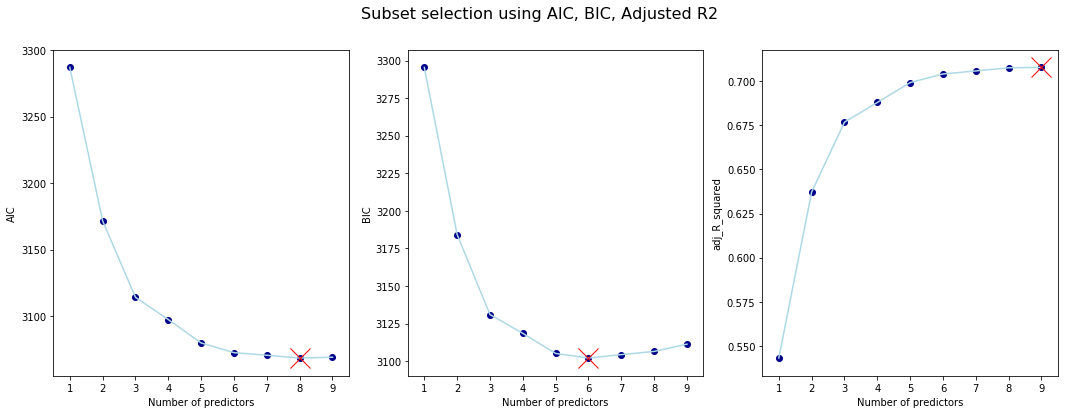

In [21]:
standards = ['AIC','BIC','adj_R_squared']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(standards):
    ax = fig.add_subplot(1, len(standards), i+1)
    ax.plot(df_results['numb_features'],df_results[v], color = 'lightblue')
    ax.scatter(df_results['numb_features'],df_results[v], color = 'darkblue')
    if v == 'adj_R_squared':
        ax.plot(df_results[v].idxmax(),df_results[v].max(), marker = 'x', markersize = 20, color='r')
    else:
        ax.plot(df_results[v].idxmin(),df_results[v].min(), marker = 'x', markersize = 20, color='r')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

## We can define a function to ensulate the two methods

In [22]:
def best_subset(y, X):
    import itertools
    from tqdm import tnrange, tqdm_notebook #Importing tqdm for the progress bar
    RSS_list, R_squared_list,adj_R_squared_list, AIC_list, BIC_list, feature_list = [],[],[],[],[],[]
    numb_features = []
    k = len(X.columns)
    #Looping over k = 1 to k = 11 features in X
    for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'): # note that for python range(2) = 0,1

        #Looping over all possible combinations: from 11 choose k
        for combo in itertools.combinations(X.columns,k):
            X_c = sm.add_constant(X[list(combo)])       # we need to add constant term using sm.OLS
            model = sm.OLS(y, X_c).fit()                # run the regression model
            RSS_list.append(model.ssr)                  # model.ssr is the sum of squared residuals
            R_squared_list.append(model.rsquared)
            adj_R_squared_list.append(model.rsquared_adj)
            AIC_list.append(model.aic)
            BIC_list.append(model.bic)
            feature_list.append(combo)
            numb_features.append(len(combo))   

    # Store the results in DataFrame
    df_results = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list,'R_squared':R_squared_list,
                               'features':feature_list,'adj_R_squared':adj_R_squared_list,'AIC':AIC_list,'BIC':BIC_list})
    return df_results

In [23]:
def forward_stepwise(y, X, remaining_features):
    features = []
    RSS_list, R_squared_list, adj_R_squared_list, AIC_list, BIC_list = [],[],[],[],[] 
    features_list = dict()                                    # Intialize feature list using dictionary. This is one way
    k = len(remaining_features)
    for i in range(1,k+1):
        best_RSS = np.inf                                     # initialize the best_RSS in each round to be infinity

        for combo in itertools.combinations(remaining_features,1): # iterate through all remaining features

            X_c = sm.add_constant(X[list(combo) + features])  # we need to add constant term using sm.OLS
            model = sm.OLS(y, X_c).fit()

            if model.ssr < best_RSS:                          # compare the RSS value with the smallest value in this round
                best_RSS = model.ssr                          # update the best value
                best_R_squared = model.rsquared               # update best best_R_squared
                best_feature = combo[0]                       # the best feature in this round
                best_aic = model.aic
                best_bic = model.bic
                best_adj_R_squared = model.rsquared_adj

        #Updating variables for next loop
        features.append(best_feature)                         # add the best feature in the features set
        remaining_features.remove(best_feature)               # remove it from candidate set

        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        AIC_list.append(best_aic)
        BIC_list.append(best_bic)
        adj_R_squared_list.append(best_adj_R_squared)
        features_list[i] = features.copy()

    # store results in df_results, which is a joint of df_features and df_values
    df_features = pd.DataFrame({'features':features_list})
    df_values = pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list,'AIC':AIC_list,'BIC':BIC_list, 'adj_R_squared': adj_R_squared_list})
    df_values.index += 1  # shift the index by 1 to get aligned with df_features
    df_results = pd.concat([df_features,df_values], axis=1, join='inner')
    df_results['numb_features'] = df_results.index
    return df_results

In [36]:
def plot_selection(df_results, standards):
    fig = plt.figure(figsize = (18,6))

    for i,v in enumerate(standards):
        ax = fig.add_subplot(1, len(standards), i+1)
        ax.plot(df_results['numb_features'],df_results[v], color = 'lightblue')
        ax.scatter(df_results['numb_features'],df_results[v], color = 'darkblue')
        if v == 'adj_R_squared':
            ax.plot(df_results[v].idxmax(),df_results[v].max(), marker = 'x', markersize = 20, color='r')
        else:
            ax.plot(df_results[v].idxmin(),df_results[v].min(), marker = 'x', markersize = 20, color='r')
        ax.set_xlabel('Number of predictors')
        ax.set_ylabel(v)

    fig.suptitle('Subset selection using ' + ", ".join(standards), fontsize = 16)
    plt.show()

## Best subset vs. forward stepwise

In [37]:
#Initialization variables
y = target
X = df_dummy.drop(columns=['ZN','INDUS','NOX','RAD','AGE','PTRATIO','B']) # we don't include these variables in the model
df_results_BS = best_subset(y, X)

In [38]:
#Initialization variables
y = target
X = df_dummy.drop(columns=['ZN','INDUS','NOX','RAD','AGE','PTRATIO','B'])     # we don't include these variables in the model
remaining_features = list(X.columns.values)               # Initialize the remaining features as all features
df_results_FS = forward_stepwise(y, X, remaining_features)

In [39]:
df_results_BS

,numb_features,RSS,R_squared,features,adj_R_squared,AIC,BIC
0,1,36275.512356,0.150780,"(CRIM,)",0.149096,3601.780731,3610.233804
1,1,22061.879196,0.483525,"(RM,)",0.482501,3350.151117,3358.604191
2,1,40048.048843,0.062464,"(DIS,)",0.060604,3651.842869,3660.295942
3,1,33338.961320,0.219526,"(TAX,)",0.217977,3559.066134,3567.519207
4,1,19472.381418,0.544146,"(LSTAT,)",0.543242,3286.974957,3295.428030
...,...,...,...,...,...,...,...
58,5,14238.477137,0.666673,"(CRIM, RM, DIS, LSTAT, CHAS_1.0)",0.663340,3136.572079,3161.931299
59,5,14404.723273,0.662782,"(CRIM, RM, TAX, LSTAT, CHAS_1.0)",0.659409,3142.445828,3167.805048
60,5,17344.710542,0.593956,"(CRIM, DIS, TAX, LSTAT, CHAS_1.0)",0.589895,3236.425934,3261.785154
61,5,13864.031415,0.675439,"(RM, DIS, TAX, LSTAT, CHAS_1.0)",0.672194,3123.087108,3148.446328


In [40]:
df_results_FS

,features,RSS,R_squared,AIC,BIC,adj_R_squared,numb_features
1,[LSTAT],19472.381418,0.544146,3286.974957,3295.428030,0.543242,1
2,"[LSTAT, RM]",15439.309201,0.638562,3171.542314,3184.221924,0.637124,2
3,"[LSTAT, RM, CHAS_1.0]",14890.780448,0.651403,3155.237995,3172.144142,0.649320,3
4,"[LSTAT, RM, CHAS_1.0, TAX]",14477.237075,0.661084,3142.986657,3164.119340,0.658378,4
5,"[LSTAT, RM, CHAS_1.0, TAX, DIS]",13864.031415,0.675439,3123.087108,3148.446328,0.672194,5
6,"[LSTAT, RM, CHAS_1.0, TAX, DIS, CRIM]",13772.845134,0.677574,3121.748060,3151.333817,0.673697,6


/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


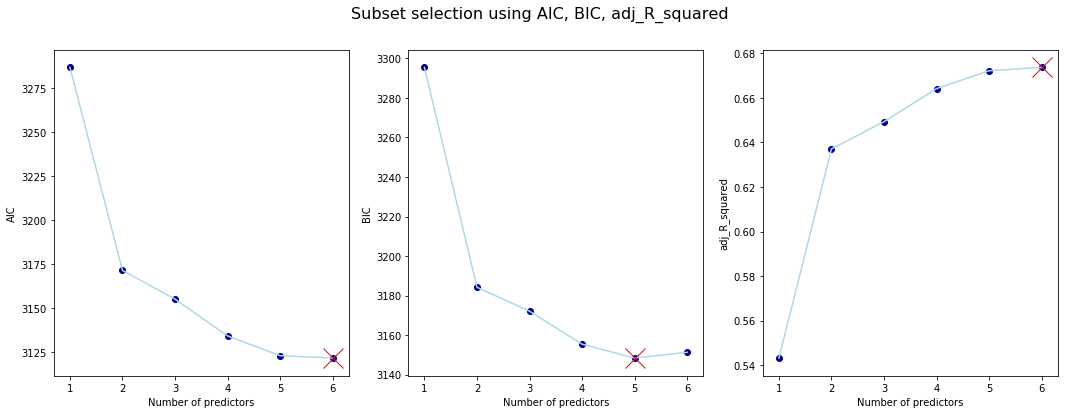

In [41]:
df_maxRsqr = df_results_BS[df_results_BS.groupby('numb_features')['R_squared'].transform(max) == df_results_BS['R_squared']] # Get max R^2 for each number of predictors
df_maxRsqr.index = df_maxRsqr.numb_features
standards = ['AIC','BIC','adj_R_squared']
plot_selection(df_maxRsqr, standards)

/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chenghua/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


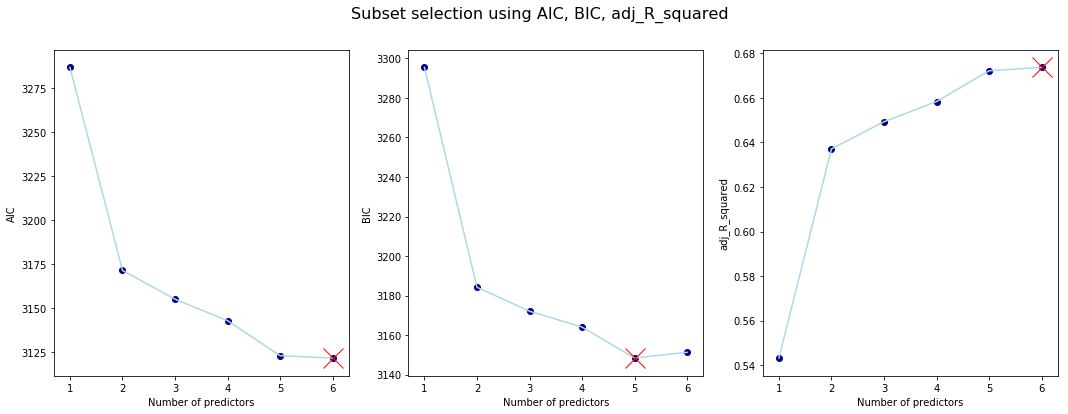

In [42]:
standards = ['AIC','BIC','adj_R_squared']
plot_selection(df_results_FS, standards)